# 3G Data Plan Prices in Lebanon

In the following I will analyze different 3G data plans provided in Lebanon.

Prices at different points in time where collected from the provider [touch](https://touch.com.lb/).

Another mobile provider in Lebanon exist, but it provides the same prices since both touch and [alfa](https://www.alfa.com.lb/) are "state-owned"(?) and sleeping in the same bed.

As we say: "طيزان بفرد لباس" / "two ass cheeks in the same pants".

In [46]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cycler
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.cm

import numpy as np
import pandas as pd
import math
import statsmodels.api as sm

from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

def get_cycle(cmap, N=None, use_index="auto"):
    if isinstance(cmap, str):
        if use_index == "auto":
            if cmap in ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']:
                use_index=True
            else:
                use_index=False
        cmap = matplotlib.cm.get_cmap(cmap)
    if not N:
        N = cmap.N
    if use_index=="auto":
        if cmap.N > 100:
            use_index=False
        elif isinstance(cmap, LinearSegmentedColormap):
            use_index=False
        elif isinstance(cmap, ListedColormap):
            use_index=True
    if use_index:
        ind = np.arange(int(N)) % cmap.N
        return cycler("color",cmap(ind))
    else:
        colors = cmap(np.linspace(0,1,N))
        return cycler("color",colors)

## The Data

Data collected are in the following files: 1 -> 5 from older to newer, 5 being the recent pricing plans.

In [6]:
touch_files = ["lb-touch-1.csv", "lb-touch-2.csv",
                "lb-touch-3.csv", "lb-touch-4.csv",
                "lb-touch-5.csv"]

The following plot exhibits the data:

- On the $x$ axis we have the plan, i.e. the quota in GB
- On the $y$ axis we have the price in USD.

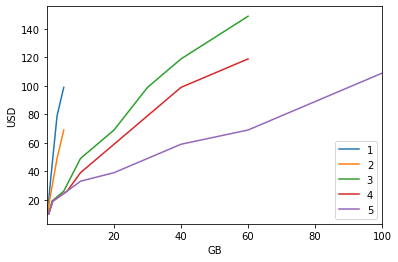

In [7]:
fig, ax = plt.subplots()

for idx, f in enumerate(touch_files):
    df = pd.read_csv(f)
    df.plot(ax=ax, kind="line", x="quota", y="price", label=str(idx + 1))

ax.set_xlabel("GB")
ax.set_ylabel("USD")

fig.show()

## Price vs Quota

It's fairly trivial to see that prices increase linearly.

I'm going to prove it doing a linear regression on the datasets, just because I have excess in computational power.

In [8]:
def price_vs_quota_ols_model(dataset):
    df = pd.read_csv(dataset)

    model_X = df["quota"]
    model_y = df["price"]

    model_X = sm.add_constant(model_X)
    model = sm.OLS(model_y, model_X).fit()

    return model

R<sup>2</sup> is high indeed all the datasets. Here's an example

In [9]:
print(price_vs_quota_ols_model(touch_files[4]).summary())

OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     306.8
Date:                Wed, 01 Apr 2020   Prob (F-statistic):           4.87e-07
Time:                        20:20:06   Log-Likelihood:                -25.813
No. Observations:                   9   AIC:                             55.63
Df Residuals:                       7   BIC:                             56.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.7726      2.234      8.405      0.000      13.491      24.054
q

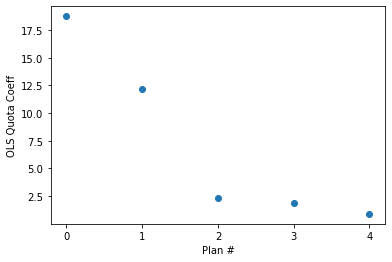

In [10]:

x = range(len(touch_files))
y = []

for f in touch_files:
    model = price_vs_quota_ols_model(f)
    y.append(model.params.quota)

fig, ax = plt.subplots()

plt.scatter(x, y)

ax.set_xlabel("Plan #")
ax.set_ylabel("OLS Quota Coeff")
xint = range(min(x), math.ceil(max(x))+1)
plt.xticks(xint)

fig.show()


But *how good is it for the consumer*?

It surely looks like the difference in plan prices is becoming less and less agressive every time they adjust the pricings, but how much are we really paying for a GB?

## Price Per GB

The following graph shows how much 1 GB of data costs in USD

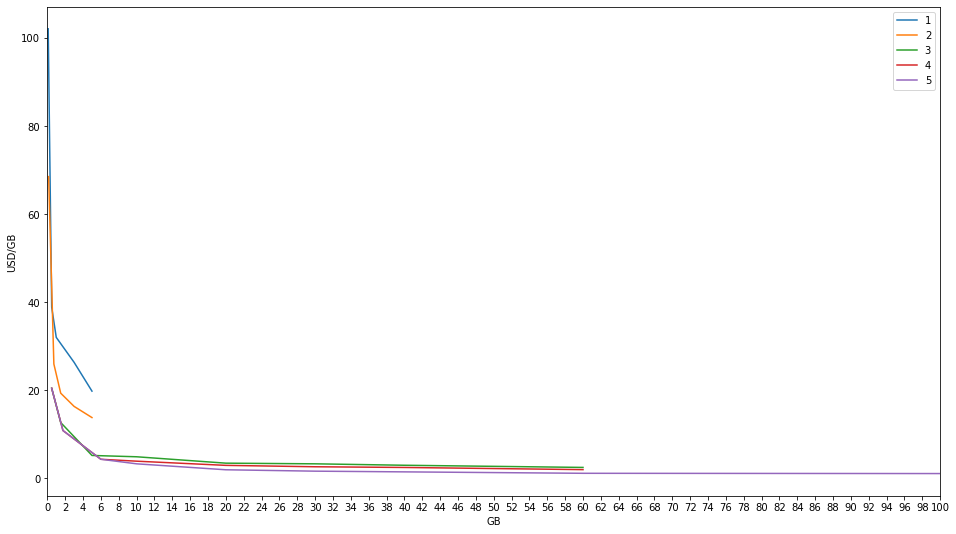

In [11]:
fig, ax = plt.subplots(figsize=(16,9))

for idx, f in enumerate(touch_files):
    df = pd.read_csv(f)
    df["per_dollar"] = df["price"] / df["quota"]
    df.plot(ax=ax, loglog=False, kind="line", x="quota", y="per_dollar", label=str(idx + 1))

ax.set_xlabel("GB")
ax.set_ylabel("USD/GB")
xint = range(0, 101,2)
plt.xticks(xint)

fig.show()

I don't know about you, but multiple things are clear:

1. The only significant decrease in pricing happened once. TODO: get the exact dates.
1. 2 clusters of pricings exists
   1. In the first cluster `(0, 1)`, a shift in prices happened.
   1. In the second cluster `(2, 3, 4)`, no significant changes seem to happen. It's merely a marketing campaign. Or Lies. I prefer to use the term lies.

But to really understand what's happening, we need to plot the graph on a loglog scale, because obviously we have exponential pricing schemes going on.

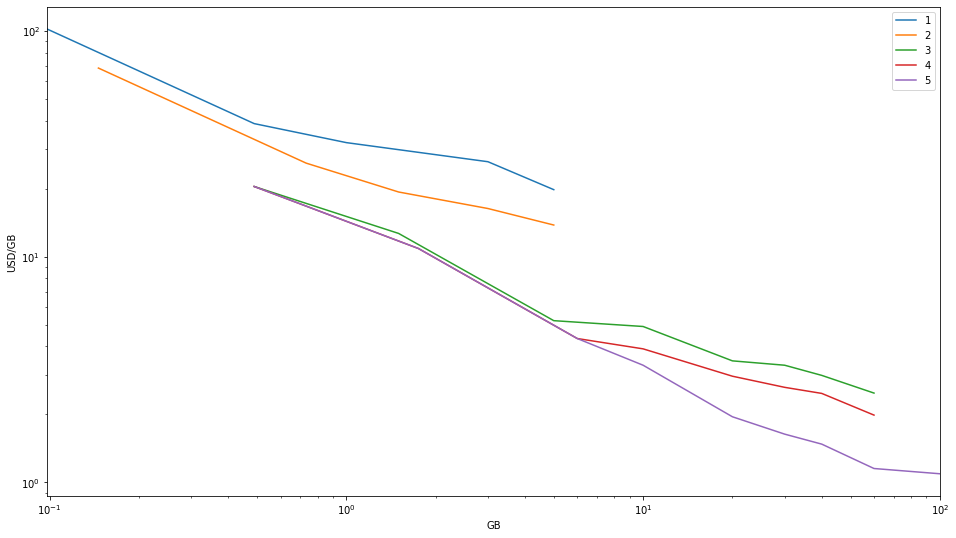

In [12]:
fig, ax = plt.subplots(figsize=(16,9))

for idx, f in enumerate(touch_files):
    df = pd.read_csv(f)
    df["per_dollar"] = df["price"] / df["quota"]
    df.plot(ax=ax, loglog=True, kind="line", x="quota", y="per_dollar", label=str(idx + 1))

ax.set_xlabel("GB")
ax.set_ylabel("USD/GB")
fig.show()

So maybe it was early to judge the price drops in the first cluster, but let's be honest for a moment, the new plot shows that:

1. Prices decrease exponentially the more you pay.
2. The last 3 changes in pricing are really changes on the higher end of the plans. Still an exponential scheme, but less aggressively so.

After doing a $log_{10}$ transform on the data, we can do a linear regression to see *how much exactly the prices drop*.

In [13]:
def price_per_GB_vs_quota_ols_model(dataset):
    df = pd.read_csv(dataset)

    model_X = np.log10(df["quota"])
    model_y = np.log10(df["price"] / df["quota"])

    model_X = sm.add_constant(model_X)
    model = sm.OLS(model_y, model_X).fit()

    return model

Here's the summary on the current pricing. All the datasets show very high R<sup>2</sup>.

In [14]:
print(price_per_GB_vs_quota_ols_model(touch_files[4]).summary())

OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     582.3
Date:                Wed, 01 Apr 2020   Prob (F-statistic):           5.34e-08
Time:                        20:20:09   Log-Likelihood:                 14.949
No. Observations:                   9   AIC:                            -25.90
Df Residuals:                       7   BIC:                            -25.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1217      0.032     35.109      0.000       1.046       1.197
q

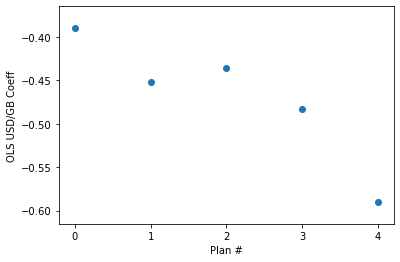

In [15]:
x = range(len(touch_files))
y = []

for f in touch_files:
    model = price_per_GB_vs_quota_ols_model(f)
    y.append(model.params.quota)

fig, ax = plt.subplots()

plt.scatter(x, y)

ax.set_xlabel("Plan #")
ax.set_ylabel("OLS USD/GB Coeff")
xint = range(min(x), math.ceil(max(x))+1)
plt.xticks(xint)

fig.show()

The pricing model is the following:

\begin{equation}
p =  10^{\beta} \times q^{\alpha}
\end{equation}

Where:
- $p$ is the price per GB
- $q$ is the quota
- $\alpha$ and $\beta$ are the USD/GB factor and the bias, respectively, from the OLS regression in log-log space.

For example, in the current pricing, $\alpha = -0.5901$ and $\beta = 1.1217$.

I started with the quest of finding the optimal price, but studying these equations for some time (and recalling human greed), 
I find the question a bit stupid:

The ideal scenario is when I pay $\$0$ and get $+\infty$ GB. Alas, reality is a bitch, where the optimal price to pay is always going to be the highest ever,
especially when a beautiful exponential is at hand.

Formally, to find the optimal price per GB, we take the derivative of $p$ w.r.t. $q$, and set it to $0$:

\begin{equation}
\frac{d}{dq} p = p' = 10^{\beta} \times \alpha \times q^{\alpha - 1}
\end{equation}

Intuitively, $p'$ represents the rate of change in $p$, the price per GB; $p' = -10$ means that the price per GB is decreasing by 10 folds.

$p'$ will reach $0$ on the limit when $x \to +\infty$. Which is practically never in our case: the more you pay, the better the gains are.

Plotting the derivative $p'$ is interesting though:

In [113]:
def usd_per_gb_rate_from_estimation(alpha, beta, min_rate_of_change=-10, max_rate_of_change=-.1, samples=1000):
    rate = np.linspace(min_rate_of_change, max_rate_of_change, samples)
    quota = (rate * (1/(alpha * 10**(beta))))**(1/(alpha - 1))
    return quota, rate

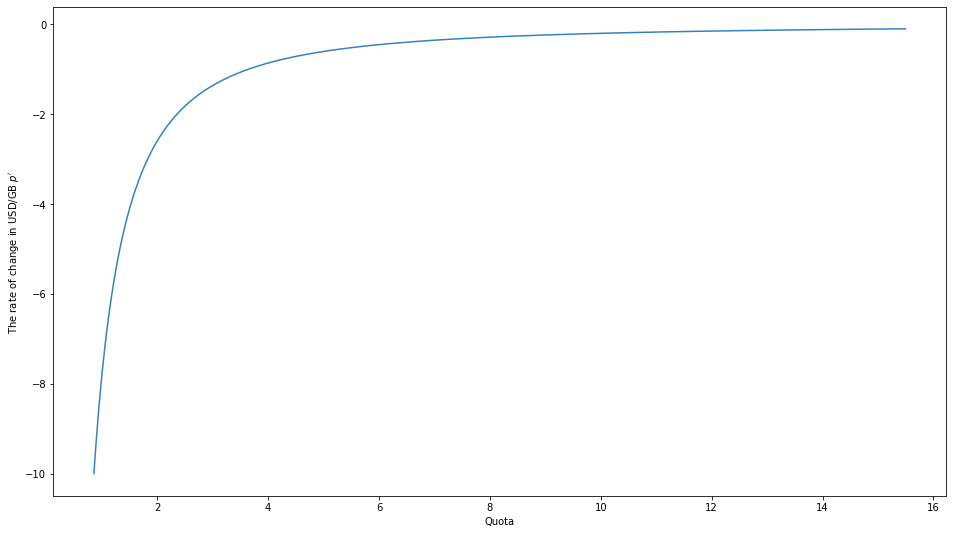

In [114]:
alpha              = -0.5901
beta               = 1.1217
min_rate_of_change = -10
max_rate_of_change = -.1

quota, rate = usd_per_gb_rate_from_estimation(alpha, beta, min_rate_of_change, max_rate_of_change)

fig, ax = plt.subplots(figsize=(16,9))

plt.plot(quota, rate)
ax.set_xlabel("Quota")
ax.set_ylabel(r"The rate of change in USD/GB $p'$")
fig.show()


The question is now *"how much do I like to get raped by the telecom company?*.

It seems to me that any plan that offers less than 6 GB of data is the on the very rapy end of the spectrum.

So if you can afford it, get any plan $\ge$ 6 GB.

## Comparing with other countries

I am going to compare data plans of Lebanon with a handful of countries, just to get an idea on how do we compare with others:

1. Syria: MTN (Syriatel promote a website and provides none)
1. Jordan: Orange, Umniah, and Zain
1. Egypt: Orange and Vodafone
1. Israel: Partner, Pelephone, and we4g
1. KSA: STC, Zain, Mobily, and Jawwy
1. Kuwait: Orderoo, STC, and Zain
1. France: Free, Orange, SF, and sosh
1. Netherlands: T-Mobile and Vodafone
1. South Korea: KT
1. African countries ....

The comparison with some of these countries is a little bit misleading. For example, providers in Jordan offer "nightime" data cap, with special caps for Facebook, or social media in general, which makes it difficult to compare with "pure" data plans. I observed the same behaviour in Israel as well, where providers offer unlimited caps on the most famous social media sites. Some of the providers offer unlimited text/call in certain scenarios bundeled with the data plan, but I'll pretend these offers don't exist.

I am trying to compare apples to apples as much as a Golden can be compared to a Gala. I am not comparing data prices, but data bundles as offered by providers. Whenever possible, I will ignore plans including calls and consider data-only offers, to make it comparable with Lebanon.



In [162]:
telcos = {
    "Lebanon-Touch": "lb-touch-5.csv",
    "Syria-MTN": "sy-mtn.csv",
    "Jordan-Orange": "jo-orange.csv",
    "Jordan-Umniah": "jo-umniah.csv",
    "Egypt-Orange": "eg-orange.csv",
    "Egypt-Vodafone": "eg-vodafone.csv",
    "Israel-Cellcom": "il-cellcom.csv",
    "Israel-Partner": "il-partner.csv",
    "KSA-STC": "ksa-stc.csv",
    "KSA-Mobily": "ksa-mobily.csv",
    "Kuwait-STC": "kw-stc.csv",
    "Kuwait-Zain": "kw-zain.csv",
    "France-Free": "fr-free.csv",
    "France-Orange": "fr-orange.csv",
    "Netherlands-T-Mobile": "nl-tmobile.csv",
    "Netherlands-Vodafone": "nl-vodafone.csv",
    "South Korea-KT": "kr-kt.csv",
}

# this is median wealth
median_wealth = {
    "Lebanon-Touch": 3932,
    "Syria-MTN": 500,
    "Jordan-Orange": 5745,
    "Jordan-Umniah": 5745,
    "Egypt-Orange": 346,
    "Egypt-Vodafone": 346,
    "Israel-Cellcom": 54966,
    "Israel-Partner": 54966,
    "KSA-STC": 12847,
    "KSA-Mobily": 12847,
    "Kuwait-STC": 26278,
    "Kuwait-Zain": 26278,
    "France-Free": 106827,
    "France-Orange": 106827,
    "Netherlands-T-Mobile": 114935,
    "Netherlands-Vodafone": 114935,
    "South Korea-KT": 65463,
}

for m in median_wealth:
    median_wealth[m] = median_wealth[m]/12.0

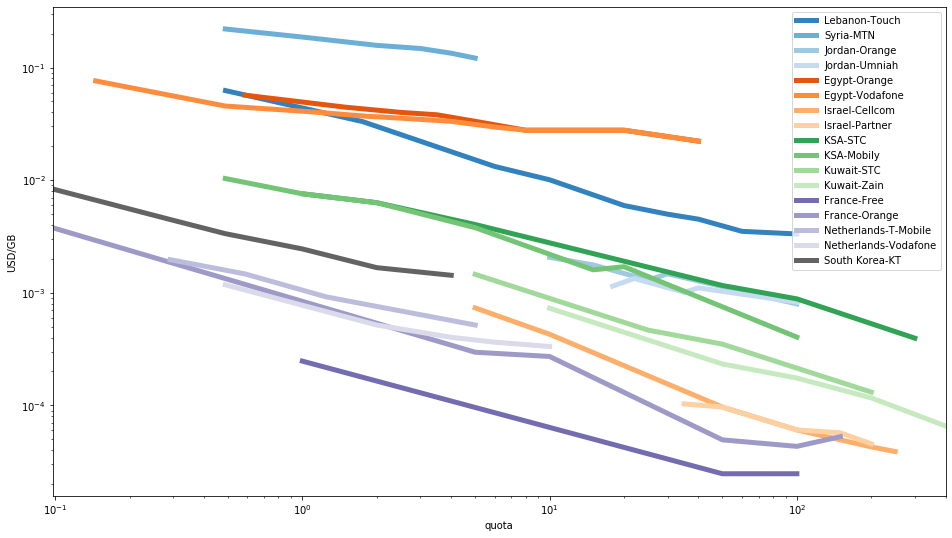

In [166]:
fig, ax = plt.subplots(figsize=(16,9))

telcos_df = {}

plt.rcParams["axes.prop_cycle"] = get_cycle("tab20c")

for i in telcos:
    df = pd.read_csv(telcos[i])
    df["per_dollar"] = df["price"] / df["quota"] / median_wealth[i]
    telcos_df[i] = df
    df.plot(ax=ax, loglog=True, kind="line", lw=5, x="quota", y="per_dollar", label=i)

ax.set_ylabel("USD/GB")
fig.show()

Telco                R^2                  p-value
==
Lebanon-Touch        0.9881219496786076   5.3401848944196376e-08
Syria-MTN            0.9883155667623889   5.13979669945138e-05
Jordan-Orange        0.9607502736943642   0.003339925382990453
Jordan-Umniah        0.7760214571911364   0.04843667167623412
Egypt-Orange         0.9648623302572371   2.3997231297643833e-06
Egypt-Vodafone       0.9338167912698113   1.3129604400869213e-06
Israel-Cellcom       0.9893527684772376   4.266311321373258e-05
Israel-Partner       0.9688710465132573   0.0023531030680781365
KSA-STC              0.9922587084079658   1.7952168267827788e-06
KSA-Mobily           0.9716942150077282   4.6238992827047944e-05
Kuwait-STC           0.995531779498566    0.002236611466142247
Kuwait-Zain          0.9929066618419727   0.0002540923432409514
France-Free          0.980470643206375    0.08925815541755933
France-Orange        0.9742610600791379   0.0002505977687460189
Netherlands-T-Mobile 0.9942189914131627   0.000186874

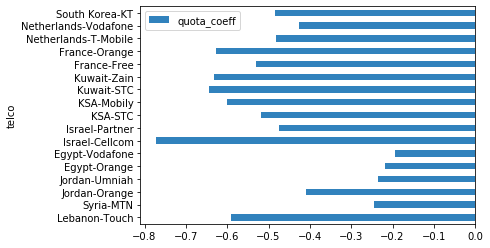

In [168]:
telco_str = "Telco"
r_squared_str = "R^2"
p_value_str = "p-value"
print(f"{telco_str:<20} {r_squared_str:<20} {p_value_str}")
print(f"==")

telcos_df = pd.DataFrame(columns=['telco', 'quota_coeff', 'bias'])

fig, ax = plt.subplots()

for i in telcos:
    model = price_per_GB_vs_quota_ols_model(telcos[i])
    telcos_df = telcos_df.append({"telco": i, "quota_coeff": model.params.quota, "bias": model.params.const}, ignore_index=True)
    print(f"{i:<20} {model.rsquared:<20} {model.pvalues.quota}")

telcos_df.plot.barh(ax=ax, x='telco', y='quota_coeff', rot=0)


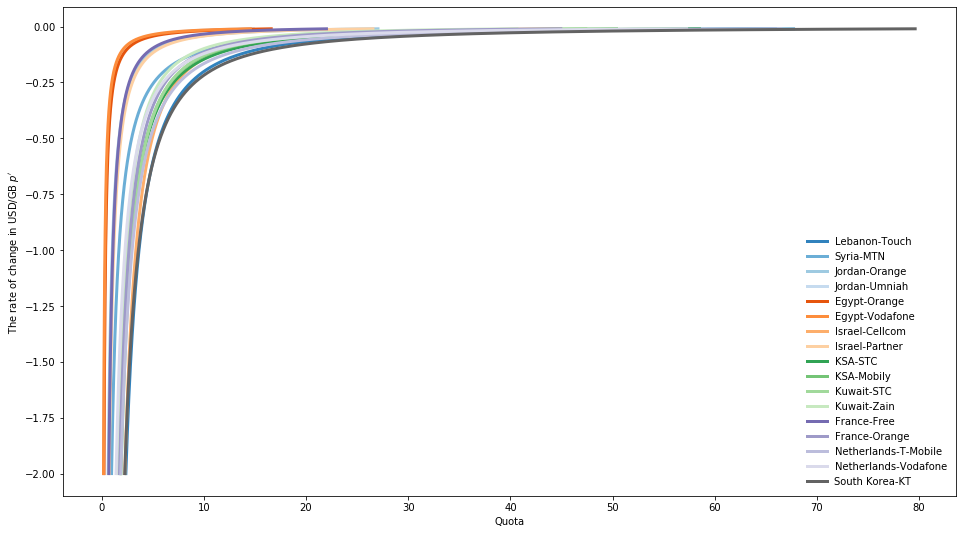

In [172]:
min_rate_of_change = -2
max_rate_of_change = -.01

fig, ax = plt.subplots(figsize=(16,9))

for idx, row in telcos_df.iterrows():
    alpha = row.quota_coeff
    beta  = row.bias

    quota, rate = usd_per_gb_rate_from_estimation(alpha, beta, min_rate_of_change, max_rate_of_change)

    plt.plot(quota, rate, lw=3, label=row.telco)

ax.set_xlabel("Quota")
ax.set_ylabel(r"The rate of change in USD/GB $p'$")
ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(loc='lower right', frameon=False)

fig.show()

## Now what?

The only conclusion I can come up with is that 3G data plans are super overpriced; Big news eh?
And the fact that the bundle cost per GB decreases exponentially makes the situation worst.

2 real price drops happened: 1 minor one between `0` and `1`, and one major between `1` and `2`.
The rest are lies. Enjoy the rape.